<a href="https://www.kaggle.com/code/francismon/fused-densenet-tiny-for-covid-19-diagnosis?scriptVersionId=91194207" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# README FIRST

# **Title: Diagnosing Covid-19 Chest X-Rays with a Lightweight Truncated DenseNet with Partial Layer Freezing and Feature Fusion**

* Author: Dr. Francis Jesmar P. Montalbo
* Affiliation: Batangas State University
* Email: francismontalbo@ieee.org; francisjesmar.montalbo@g.batstate-u.edu.ph

***PLEASE CONTANCT ME IF YOU ARE HAVING TROUBLE. I CAN OFFER ASSITANCE --> https://francismontalbo.github.io/***

This is published in an article in Biomedical Signal Processing and Control (BSPC) ISSN: 1746-8094. 

**PAPER LINKS: 
# https://www.sciencedirect.com/science/article/abs/pii/S1746809421001804 --> Main Paper
# https://www.sciencedirect.com/science/article/pii/S2215016121002016 --> Methods Paper

## If you find this helpful, please care to cite my works.

@article{MONTALBO2021102583, title = {Diagnosing Covid-19 Chest X-Rays with a Lightweight Truncated DenseNet with Partial Layer Freezing and Feature Fusion}, journal = {Biomedical Signal Processing and Control}, pages = {102583}, year = {2021}, issn = {1746-8094}, doi = {https://doi.org/10.1016/j.bspc.2021.102583}, url = {https://www.sciencedirect.com/science/article/pii/S1746809421001804}, author = {Francis Jesmar P. Montalbo}, keywords = {chest x-rays, computer-aided diagnosis, covid-19, deep learning, densely connected neural networks}

@article{MONTALBO2021101408, title = {Truncating a Densely Connected Convolutional Neural Network with Partial Layer Freezing and Feature Fusion for Diagnosing COVID-19 from Chest X-Rays}, journal = {MethodsX}, pages = {101408}, year = {2021}, issn = {2215-0161}, doi = {https://doi.org/10.1016/j.mex.2021.101408}, url = {https://www.sciencedirect.com/science/article/pii/S2215016121002016}, author = {Francis Jesmar P. Montalbo}, keywords = {Deep Convolutional Neural Networks, COVID-19, Feature Fusion, Medical Image Diagnosis, Image Classification}

# MODEL CREATION

In [1]:
# #Run this line in case the Keras Flops caused an error
# !pip install keras-flops

In [2]:
#LOAD DEPENDENCIES
import os
import time
import logging
import itertools
import scikitplot
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

from keras_flops import get_flops
from keras.utils.layer_utils import count_params
from sklearn.metrics import accuracy_score, mean_squared_error, mean_squared_log_error, classification_report, confusion_matrix, roc_curve, auc

from tensorflow.keras.models import Model
from tensorflow.keras import applications
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Layer, ReLU, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Add, Concatenate, Dropout

#PREVENT ERROR UNCESSARY MESSAGES
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

print("All packages loaded successfully!")

All packages loaded successfully!


In [3]:
#LOAD THE DATA
train_data_dir = "../input/curated-covid19-chest-xray-dataset/dataset/train"
validation_data_dir = "../input/curated-covid19-chest-xray-dataset/dataset/validation"

# THE INPUT LAYER IS THE SAME AS IT WILL BE FUSED AS ONE LATER ON
img_rows, img_cols = 224, 224
channel_depth = 3
input_shape = (img_rows,img_cols,channel_depth)
model_input = Input(shape=input_shape)
print("Data folders found!")
print("The Input size is set to ", model_input)

Data folders found!
The Input size is set to  KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


# DATA GENERATOR

In [4]:
#DATA GENERATORS
batch_size = 16

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
                                
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows,img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        classes=['0_Normal', '1_Covid19', '2_Pneumonia'])

validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows,img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        classes=['0_Normal', '1_Covid19', '2_Pneumonia'])

#CHECK  THE NUMBER OF SAMPLES
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)

if nb_train_samples == 0:
    print("NO DATA TRAIN FOUND! Please check your train data path and folders!")
else:
    print("Train samples found!")
    
if nb_validation_samples == 0:
    print("NO DATA VALIDATION FOUND! Please check your validation data path and folders!")
    print("Check the data folders first!")
else:
    print("Validation samples found!")

#check the class indices
train_generator.class_indices
validation_generator.class_indices

#true labels
Y_test=validation_generator.classes

num_classes= len(train_generator.class_indices)

if nb_train_samples and nb_validation_samples > 0:
    print("Generators are set!")
    print("Check if dataset is complete and has no problems before proceeding.")

Found 7367 images belonging to 3 classes.
Found 1841 images belonging to 3 classes.
Train samples found!
Validation samples found!
Generators are set!
Check if dataset is complete and has no problems before proceeding.


# MODEL CREATION

In [5]:
# DenseNet121-A 

#TRANSFER LEARNING
def densenet_tiny_A_builder(model_input):
    densenet_tiny_A_builder = DenseNet121(weights='imagenet', include_top=False, input_tensor=model_input)
    
#PARTIAL LAYER FREEZING
    for layer in densenet_tiny_A_builder.layers:
        layer.trainable = False 

#MODEL TRUNCATION
    x = densenet_tiny_A_builder.layers[-354].output
    model = Model(inputs=densenet_tiny_A_builder.input, outputs=x, name='densenet-tiny-A')
    return model

#GENERATE THE MODEL
densenet_tiny_A = densenet_tiny_A_builder(model_input)

#PLOT THE MODEL STRUCTURE
print("PLEASE CHECK THE ENTIRE MODEL UP TO THE END")
densenet_tiny_A.summary()
print("DenseNet-Tiny-A successfully built!")

PLEASE CHECK THE ENTIRE MODEL UP TO THE END
Model: "densenet-tiny-A"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________

In [6]:
# DenseNet121-B

#TRANSFER LEARNING
def densenet_tiny_B_builder(model_input):
    densenet_tiny_B_builder = DenseNet121(weights='imagenet', include_top=False, input_tensor=model_input)
    
#RE-TRAINING ALL LAYERS (RE-NAMING LAYERS TO PREVENT OVERLAPS)
    for layer in densenet_tiny_B_builder.layers:
        layer.trainable = True
        layer._name = layer._name + str("_mirror")

#MODEL TRUNCATION
    x = densenet_tiny_B_builder.layers[-354].output
    model = Model(inputs=densenet_tiny_B_builder.input, outputs=x, name='densenet_tiny-B')
    return model

#GENERATE THE MODEL
densenet_tiny_B = densenet_tiny_B_builder(model_input)

#PLOT THE MODEL STRUCTURE
print("PLEASE CHECK THE ENTIRE MODEL UP TO THE END")
densenet_tiny_B.summary()
print("DenseNet-Tiny-B successfully built!")

PLEASE CHECK THE ENTIRE MODEL UP TO THE END
Model: "densenet_tiny-B"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1_mirror (InputLayer)     [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2_mirror (ZeroPa (None, 230, 230, 3)  0           input_1_mirror[0][0]             
__________________________________________________________________________________________________
conv1/conv_mirror (Conv2D)      (None, 112, 112, 64) 9408        zero_padding2d_2_mirror[0][0]    
__________________________________________________________________________________________________
conv1/bn_mirror (BatchNormaliza (None, 112, 112, 64) 256         conv1/conv_mirror[0][0]          
________________________________________

# MODEL FUSION

In [7]:
#PREPARE THE CONCATENATION OF THE PRE-TRAINED MODELS
densenet_tiny_A = densenet_tiny_A_builder(model_input)
densenet_tiny_B = densenet_tiny_B_builder(model_input)

print("DenseNet-Tiny-A and DenseNet-Tiny-B accomplished Pre-training and ready for concatenation")

DenseNet-Tiny-A and DenseNet-Tiny-B accomplished Pre-training and ready for concatenation


In [8]:
#CONCATENATE AS THE MODELS AS A SINGLE PIPELINE
models = [densenet_tiny_A, 
          densenet_tiny_B]

print("Concatenation success!")
print("Fused-DenseNet-Tiny ready to connect with its ending layers!")

Concatenation success!
Fused-DenseNet-Tiny ready to connect with its ending layers!


In [9]:
#BUILD THE FUSED-DENSENET-TINY
def fused_densenet_tiny(models, model_input):
    outputs = [m.output for m in models]
    y = Add()(outputs)               
    y = GlobalAveragePooling2D()(y)
    y = Dense(512, activation='relu', use_bias=True)(y)
    y = Dropout(0.5)(y)
    prediction = Dense(num_classes,activation='softmax', name='Softmax_Classifier')(y)
    model = Model(model_input, prediction, name='fused_densenet_tiny')
    return model

#istantitate the ensemble model and report the summary
fused_densenet_tiny = fused_densenet_tiny(models,model_input)

print()
print()
print("PLEASE CHECK THE MODEL UP TO THE END")
print("Fused-DenseNet-Tiny complete and ready for compilation and training!")
print()
print()
print()

fused_densenet_tiny.summary()
print("Building of the Fused-DenseNet-Tiny COMPLETE!")



PLEASE CHECK THE MODEL UP TO THE END
Fused-DenseNet-Tiny complete and ready for compilation and training!



Model: "fused_densenet_tiny"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1_mirror_mirror (InputLay [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 230, 230, 3)  0           input_1_mirror_mirror[0][0]      
__________________________________________________________________________________________________
zero_padding2d_6_mirror (ZeroPa (None, 230, 230, 3)  0           input_1_mirror_mirror[0][0]      
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zer

# MODEL TRAINING

In [10]:
#MODEL COMPILATION WITH HYPER-PARAMETERS, LOSS FUNCTIONS AND TRAINING!
batch_size = 16

epochs = 25

optimizer = Adam(learning_rate=0.0001)

fused_densenet_tiny.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) 

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.000001)

callbacks = [reduce_lr]

#Model training begins here
start_time = time.time()
print("Model training started!")

history = fused_densenet_tiny.fit(train_generator, 
                                  steps_per_epoch=nb_train_samples // batch_size,
                                  epochs=epochs, 
                                  validation_data=validation_generator,
                                  callbacks=callbacks, 
                                  validation_steps=nb_validation_samples // batch_size, verbose=1)

elapsed_time = time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

print("Elapsed time:", elapsed_time)
print("The Fused DenseNet-Tiny is successfully trained!")

Model training started!
Epoch 1/25
460/460 [==============================] - 48s 97ms/step - loss: 0.4181 - accuracy: 0.8393 - val_loss: 0.5775 - val_accuracy: 0.7690
Epoch 2/25
460/460 [==============================] - 41s 89ms/step - loss: 0.1622 - accuracy: 0.9449 - val_loss: 0.3067 - val_accuracy: 0.8957
Epoch 3/25
460/460 [==============================] - 40s 88ms/step - loss: 0.1222 - accuracy: 0.9576 - val_loss: 0.1206 - val_accuracy: 0.9538
Epoch 4/25
460/460 [==============================] - 40s 86ms/step - loss: 0.0993 - accuracy: 0.9654 - val_loss: 0.8767 - val_accuracy: 0.7500
Epoch 5/25
460/460 [==============================] - 41s 90ms/step - loss: 0.0913 - accuracy: 0.9693 - val_loss: 0.2486 - val_accuracy: 0.9043
Epoch 6/25
460/460 [==============================] - 41s 89ms/step - loss: 0.0811 - accuracy: 0.9718 - val_loss: 0.1220 - val_accuracy: 0.9571
Epoch 7/25
460/460 [==============================] - 42s 91ms/step - loss: 0.0666 - accuracy: 0.9773 - val_loss

# MODEL EVALUATION

In [11]:
#Validation Model Results
model = fused_densenet_tiny

#evaluate accuracy
y_pred = model.predict(validation_generator, 
                                 nb_validation_samples/batch_size, workers=1)

accuracy = accuracy_score(Y_test, y_pred.argmax(axis=-1))
print('The accuracy of the ' + model._name + ' is: ', accuracy)

#evaluate mean squared error
mse = mean_squared_error(Y_test, y_pred.argmax(axis=-1))
print('The MSE of the ' + model._name + ' is: ', mse)

#evaluate mean squared log error
msle = mean_squared_log_error(Y_test, y_pred.argmax(axis=-1))  
print('The MSLE of the ' + model._name +  ' is: ', msle)

The accuracy of the fused_densenet_tiny is:  0.9701249321021184
The MSE of the fused_densenet_tiny is:  0.11135252580119501
The MSLE of the fused_densenet_tiny is:  0.033569559983783255


In [12]:
#Modify only as needed

#Figure
dpi = 1000
plt.rcParams.update({'figure.dpi': dpi})
figsize = (12, 12)

#Markers
marker_train_accuracy = 's'
marker_validation_accuracy = 'x'
marker_train_loss = 'o'
marker_validation_loss = '|'
marker_fillstyle_train = 'none'
marker_fillstyle_validation = 'none'
marker_plot_markersize = 25
marker_plot_markerwidth = 3

#Lines
line_style_train = '-' 
line_style_validation = '--'
line_width_train = '5'
line_width_val = line_width_train
line_color_train_accuracy = 'black'
line_color_val_accuracy = 'black'
line_color_train_loss = 'black'
line_color_val_loss = 'black'

#Labels
train_accuracy_label = 'Train ' + 'Acc'
validation_accuracy_label = 'Val ' + 'Acc'
train_loss_label = 'Train ' + 'Loss'
validation_loss_label = 'Val ' 'Loss'
x_label_font_size = 56
y_label_font_size = x_label_font_size
x_label_font = 'Tahoma'
y_label_font = x_label_font
# x_label_fontweight = 'bold'
# y_label_fontweight = x_label_fontweight

#Ticks
spine_axis_thickness = 4
tick_font_size = 42
tick_length = 12
tick_width = spine_axis_thickness

#Legend
legend_border_pad = 0.35
legend_line_width = 5
legend_font_size = 50
legend_edge_color = 'black'
legend_label_spacing = 0.5
legend_location = 'best'
legend_ncol = 1
legend_font = 'Tahoma'
legend_has_frame = True

<Figure size 12000x12000 with 0 Axes>

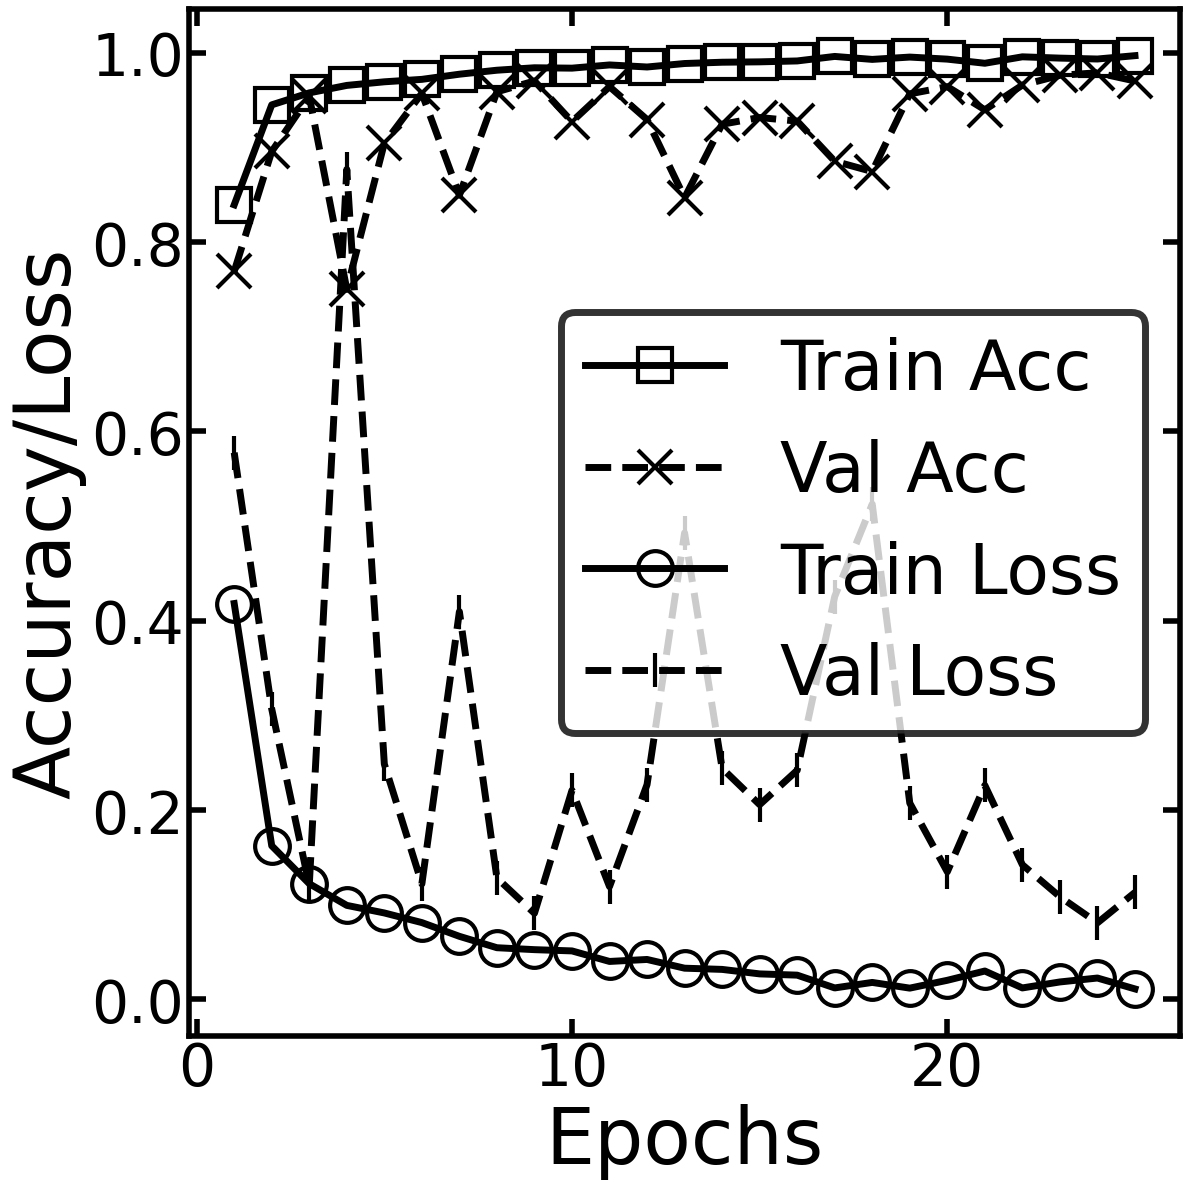

In [13]:
#Convergence
plt.style.use("default")
plt.figure(figsize = figsize, 
           dpi = dpi, 
           edgecolor = 'black', 
           facecolor = 'white', 
           linewidth = 0)

plt.tight_layout()
plt.rc('xtick', labelsize = tick_font_size, direction="in") 
plt.rc('ytick', labelsize = tick_font_size, direction="in") 

fig, ax = plt.subplots(figsize = figsize)
plt.gcf().subplots_adjust(bottom = 0.15)
plt.setp(ax.spines.values(), linewidth = spine_axis_thickness)

plt.tick_params(length = tick_length, 
                width = tick_width, 
                right = True, 
                top = True)

plt.plot(np.arange(1, epochs + 1), 
         history.history["accuracy"], 
         mew = marker_plot_markerwidth, 
         color = line_color_train_accuracy, 
         lw = line_width_train, 
         marker = marker_train_accuracy, 
         markersize = marker_plot_markersize, 
         fillstyle = marker_fillstyle_train, 
         ls = line_style_train, 
         label = train_accuracy_label)

plt.plot(np.arange(1, epochs + 1), 
         history.history["val_accuracy"], 
         mew = marker_plot_markerwidth, 
         color = line_color_val_accuracy, 
         lw = line_width_val, 
         marker = marker_validation_accuracy, 
         markersize = marker_plot_markersize, 
         fillstyle = marker_fillstyle_validation, 
         ls = line_style_validation,  
         label = validation_accuracy_label)

plt.plot(np.arange(1, epochs + 1), 
         history.history["loss"], 
         mew = marker_plot_markerwidth, 
         color = line_color_train_loss, 
         lw = line_width_train, 
         marker = marker_train_loss, 
         markersize = marker_plot_markersize, 
         fillstyle = marker_fillstyle_train, 
         ls = line_style_train, label = train_loss_label)

plt.plot(np.arange(1, epochs + 1), 
         history.history["val_loss"], 
         mew = marker_plot_markerwidth, 
         color = line_color_val_loss, 
         lw = line_width_val, 
         marker = marker_validation_loss, 
         markersize = marker_plot_markersize, 
         fillstyle = marker_fillstyle_validation, 
         ls = line_style_validation,  
         label = validation_loss_label)

plt.xlabel("Epochs", fontfamily = x_label_font, fontsize = x_label_font_size, color ='black')
plt.ylabel("Accuracy/Loss", fontfamily = y_label_font, fontsize = y_label_font_size, color = 'black')

legend = plt.legend(loc = legend_location, 
                    ncol = legend_ncol, 
                    frameon = legend_has_frame, 
                    fontsize=legend_font_size, 
                    edgecolor=legend_edge_color, 
                    borderpad=legend_border_pad, 
                    labelspacing=legend_label_spacing)

frame = legend.get_frame()
legend.get_frame().set_linewidth(legend_line_width)
legend.get_frame().set_edgecolor(legend_edge_color)
plt.setp(legend.texts, family = legend_font)
plt.tight_layout()

              precision    recall  f1-score   support

      Normal     0.9466    0.9755    0.9608       654
    COVID-19     0.9922    0.9883    0.9902       256
   Pneumonia     0.9814    0.9613    0.9712       931

    accuracy                         0.9701      1841
   macro avg     0.9734    0.9750    0.9741      1841
weighted avg     0.9705    0.9701    0.9702      1841

Normalized confusion matrix
[[0.9755 0.     0.0245]
 [0.0078 0.9883 0.0039]
 [0.0365 0.0021 0.9613]]


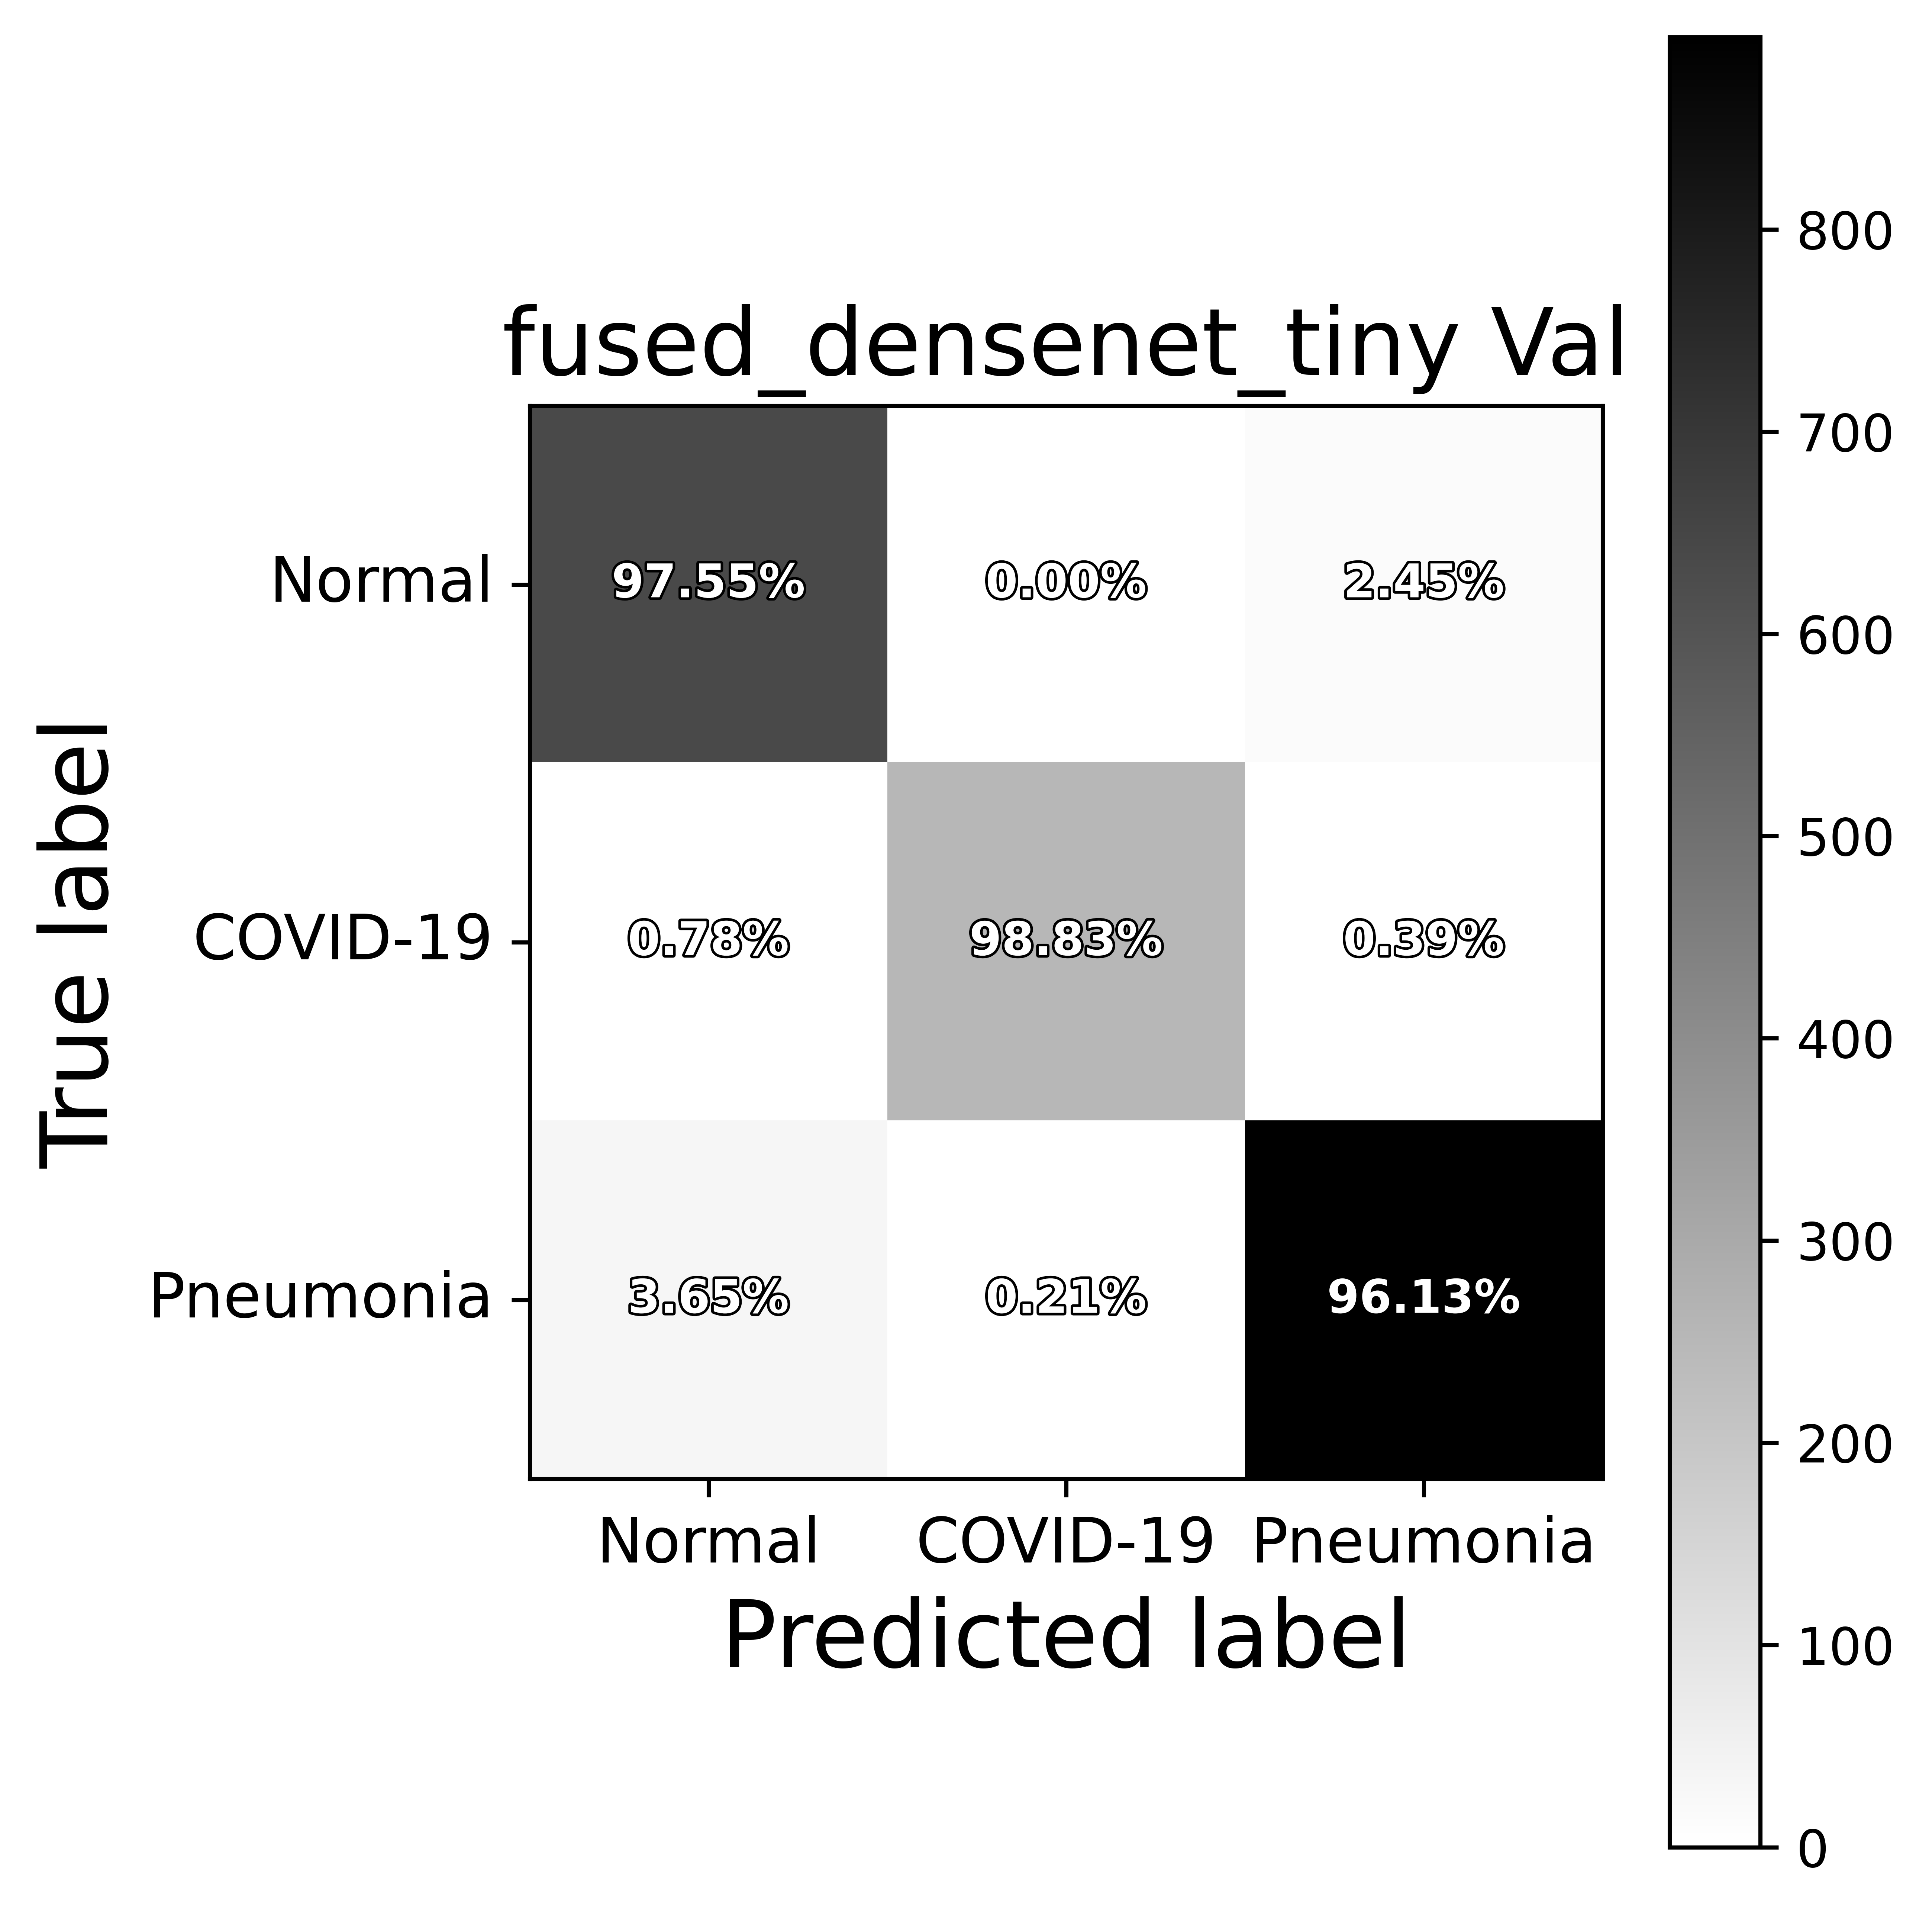

In [14]:
# Confusion Matrix (Normalized)
fontsize=12

def confusion_matrix_test(cm, classes,
                          normalize=True, #if true all values in confusion matrix is between 0 and 1
                          title=model._name + ' Val',
                          cmap=plt.cm.binary):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar(orientation='vertical')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, fontfamily = 'Tahoma', fontsize=fontsize, horizontalalignment="center")
    plt.yticks(tick_marks, classes, rotation=0, fontfamily = 'Tahoma', fontsize=fontsize, verticalalignment="center")

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        text = plt.text(j, i, '{:.2f}%'.format(cm[i, j]*100),
                 fontfamily = 'Tahoma', 
                 fontsize=9, weight='bold',
                 horizontalalignment="center", verticalalignment='center',
                 color="white" if cm[i, j] > thresh else "white")
        text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'), 
        path_effects.Normal()]),

    
    plt.tight_layout()
    plt.ylabel('True label', fontfamily = 'Tahoma', fontsize=18, horizontalalignment="center")
    plt.xlabel('Predicted label', fontfamily = 'Tahoma', fontsize=18)

#print classification report and plot confusion matrix
plt.style.use("default")
target_names = ['Normal', 'COVID-19', 'Pneumonia']
print(classification_report(Y_test,y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix_test = confusion_matrix(Y_test,y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5.25, 5.25), dpi=dpi)
confusion_matrix_test(cnf_matrix_test, classes=target_names)
plt.tight_layout()

plt.show()

In [15]:
#Re-updated plotting format for CURVES
plt.rcParams.update({'figure.figsize': [6,6]})
plt.rcParams.update({'figure.dpi': 300})
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'legend.borderpad': 0.2})
plt.rcParams.update({'legend.fontsize': 'xx-large'})
plt.rcParams.update({'legend.frameon': True})

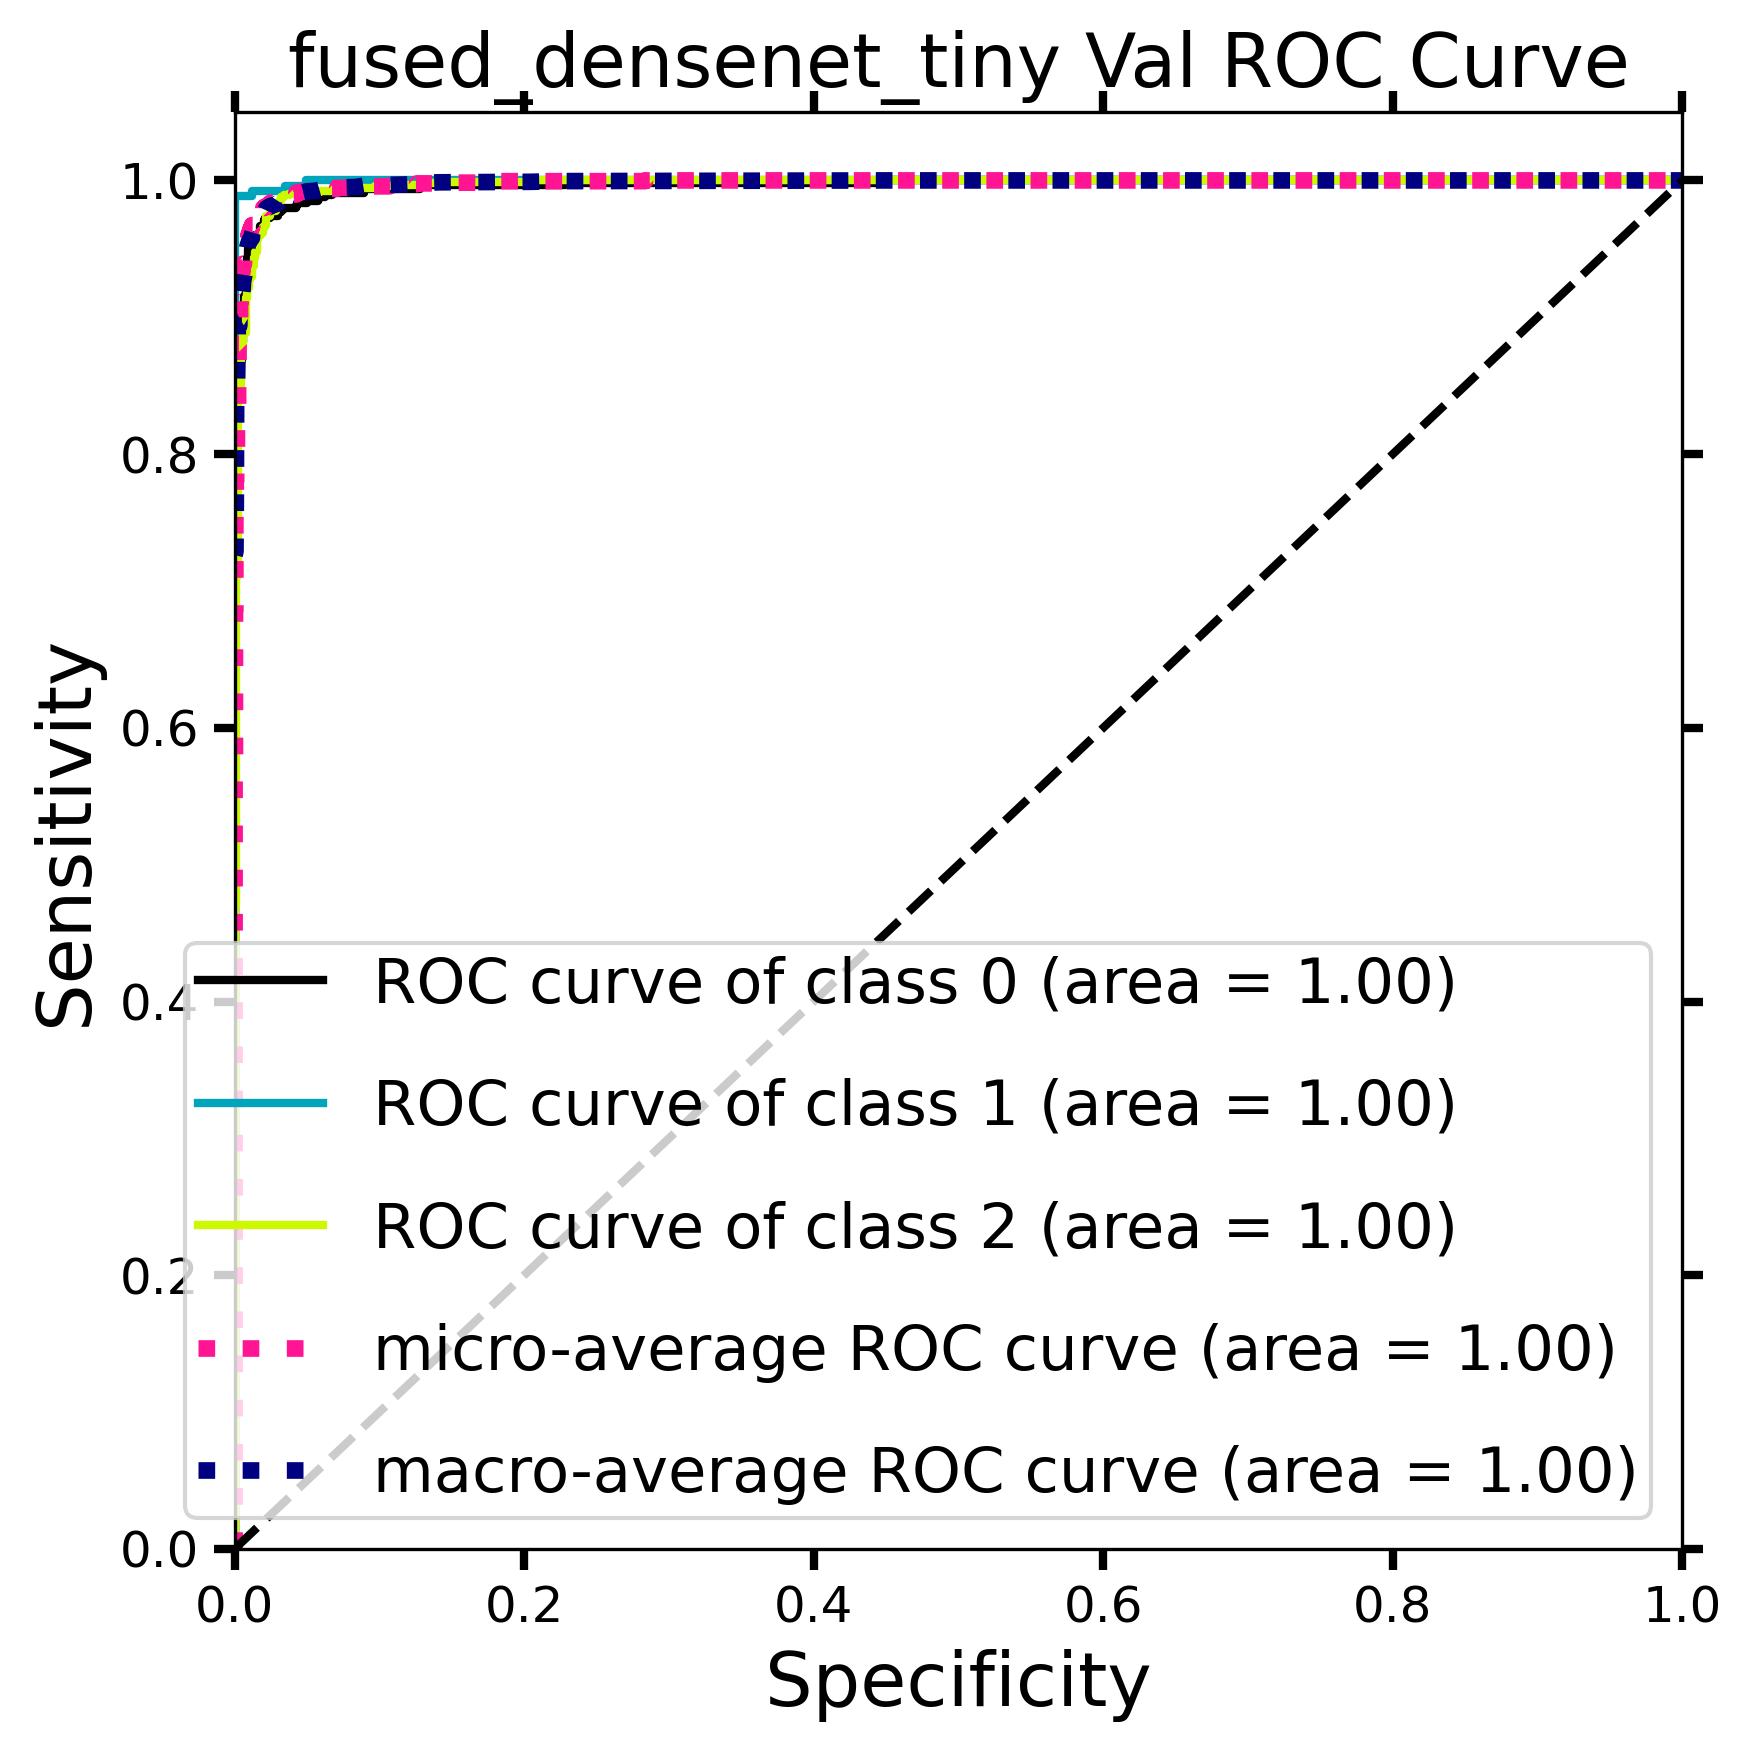

In [16]:
#ROC validation
scikitplot.metrics.plot_roc(Y_test, y_pred)
plt.title(model._name + ' Val' + ' ROC Curve', fontsize=18, fontfamily='Tahoma')
plt.xlabel('Specificity', fontsize=18, fontfamily='Tahoma')
plt.ylabel('Sensitivity', fontsize=18, fontfamily='Tahoma')

plt.tick_params(length = 5, 
                width = 2, 
                right = True, 
                top = True, 
                labelsize = 12)

plt.rc('xtick', direction="in") 
plt.rc('ytick', direction="in") 
legend = plt.legend(loc="lower right", fontsize=15, labelspacing=1)
plt.setp(legend.texts, family = 'Tahoma')

plt.tight_layout()
plt.show()

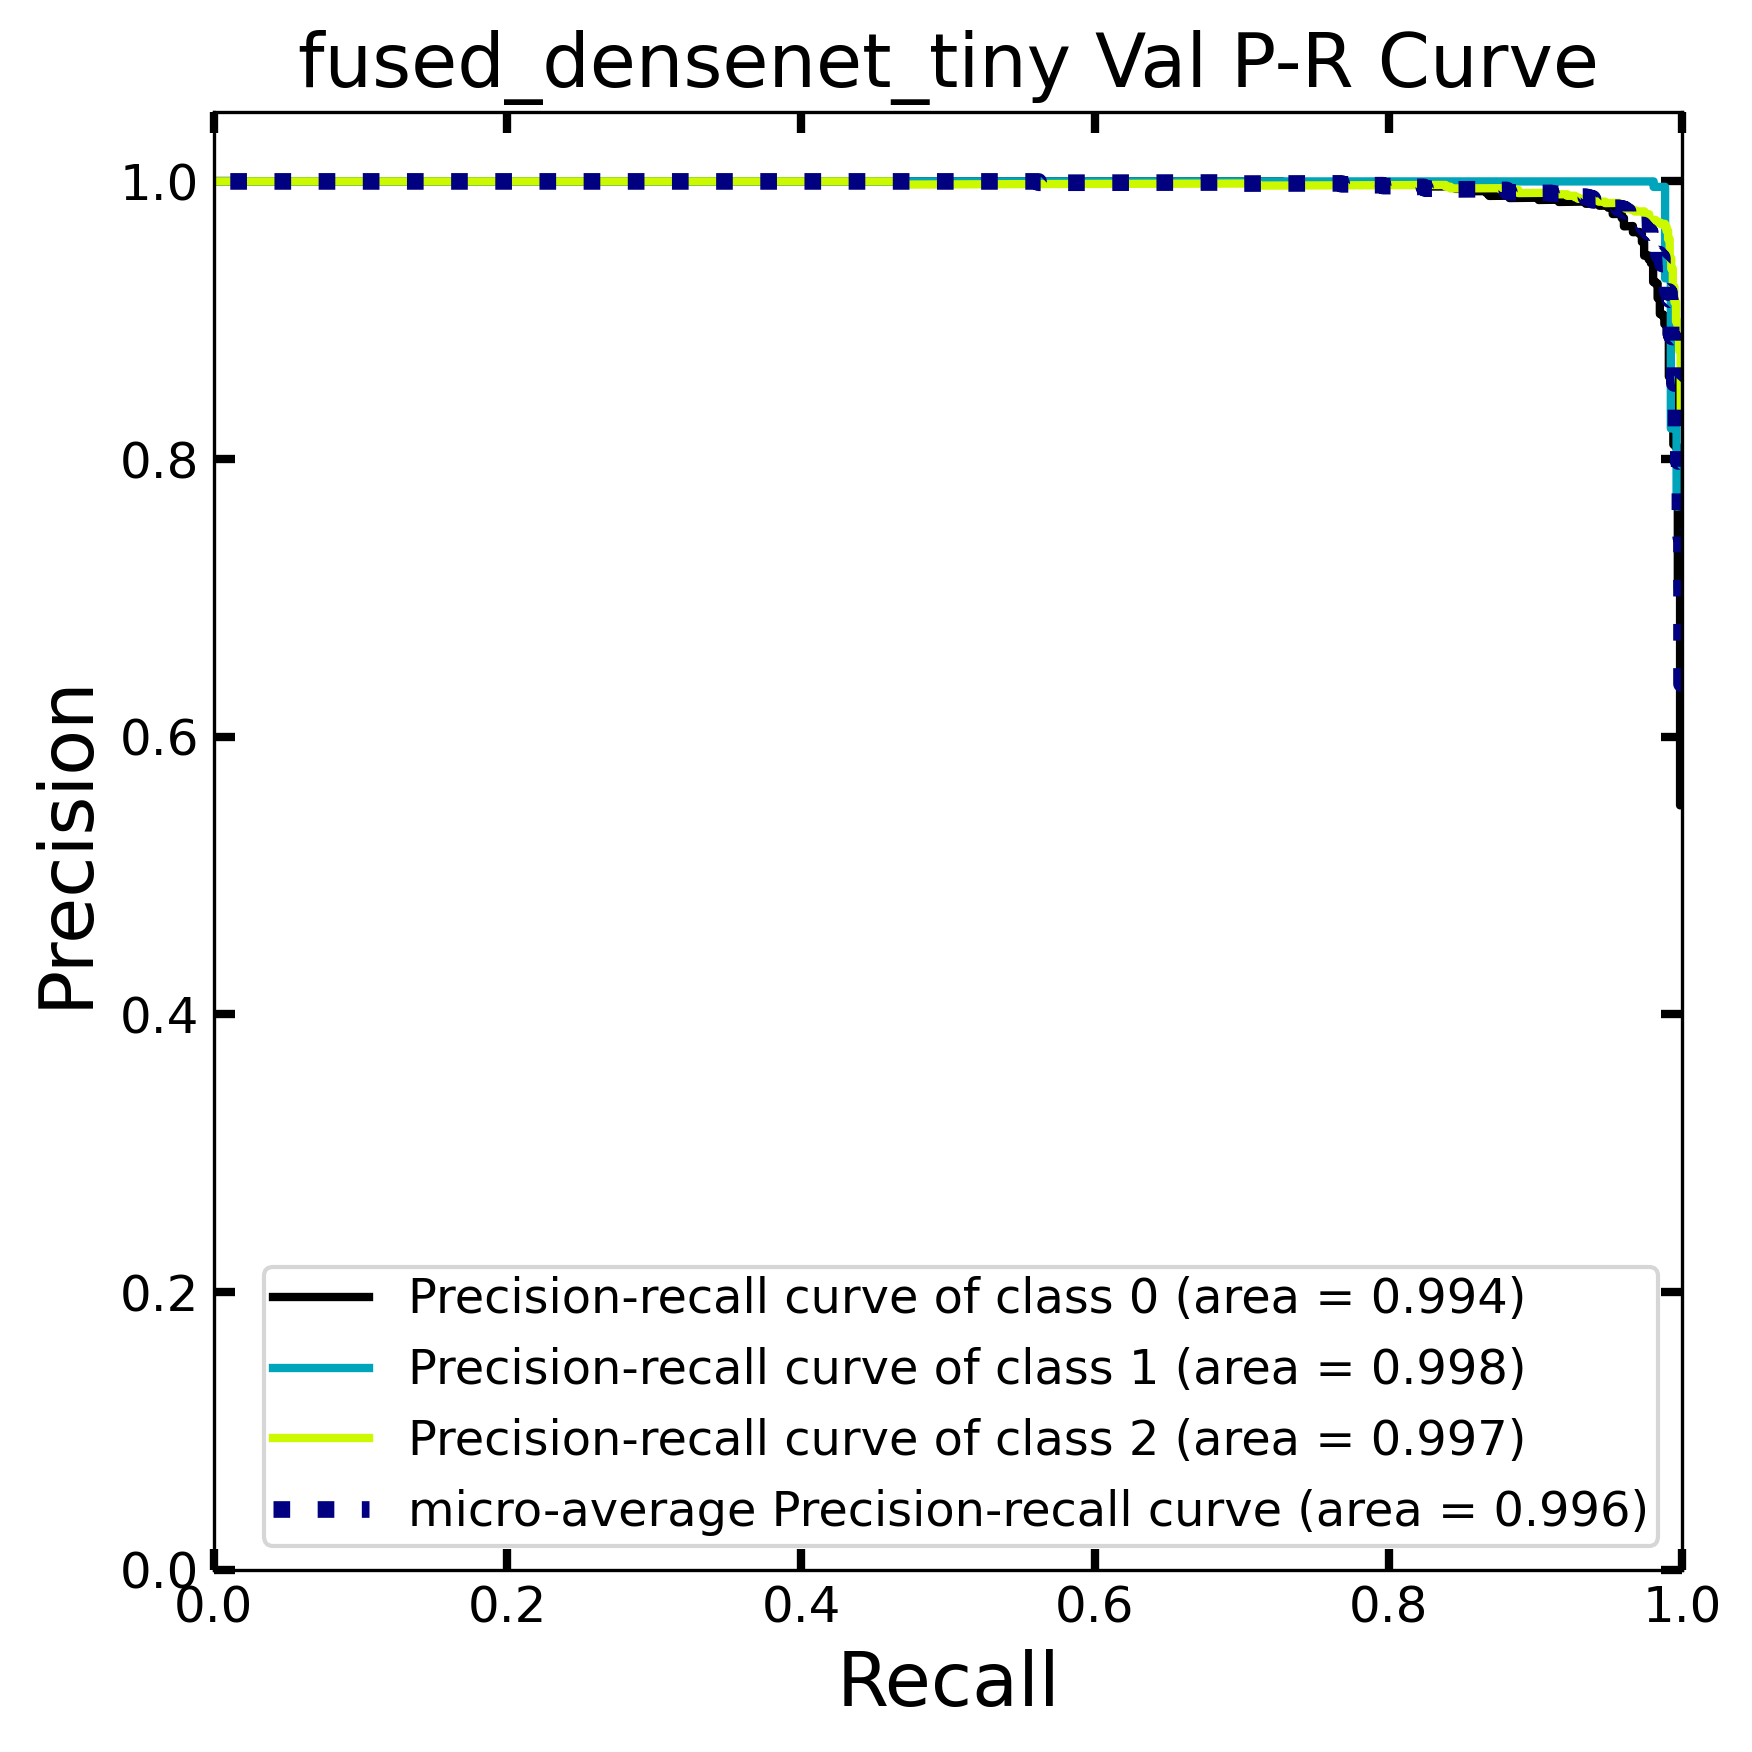

In [17]:
#P-R validation
scikitplot.metrics.plot_precision_recall(Y_test, y_pred)
plt.title(model._name + ' Val' + ' P-R Curve', fontsize=18, fontfamily='Tahoma')
plt.xlabel('Recall', fontsize=18, fontfamily='Tahoma')
plt.ylabel('Precision', fontsize=18, fontfamily='Tahoma')

plt.tick_params(length = 5, 
                width = 2, 
                right = True, 
                top = True, 
                labelsize = 12)

plt.rc('xtick', direction="in") 
plt.rc('ytick', direction="in") 
plt.legend(loc="lower right", fontsize=11.5, labelspacing=0.5)
plt.setp(legend.texts, family = 'Tahoma')

plt.tight_layout()
plt.show()

In [18]:
#Sanity check
model.evaluate(validation_generator, return_dict=True)

116/116 [==============================] - 7s 60ms/step - loss: 0.1129 - accuracy: 0.9701


{'loss': 0.1129113957285881, 'accuracy': 0.9701249599456787}

In [20]:
#Cost-efficiency
def cost_compute():
    flops  = float("{0:.2f}".format(get_flops(Model(model.input, model.output), batch_size=1)/ 10 ** 9))
    params = float("{0:.2f}".format(model.count_params() / 10 ** 6))
    trainable_count = float("{0:.2f}".format(count_params(model.trainable_weights) / 10 ** 6))
    print("FLOPS:", flops, "GFLOPS")
    print("Params:", params, "M")

cost_compute()


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi